# 🧠 Construção e Consulta de VectorStores com LangChain, ChromaDB e MistralAI

Bem-vindo! Este notebook demonstra, de forma estruturada, como criar e consultar bancos vetoriais (vectorstores) para diferentes áreas do conhecimento, utilizando PyPDF, LangChain, ChromaDB e embeddings do MistralAI.

A seguir, você verá a definição de uma classe utilitária centralizadora e, depois, como criar gestores (`manager`) para diferentes domínios, como **produtos**, **processos** e **recursos humanos**.


Instalar as dependencias

In [3]:
%pip install langchain langchain-mistralai langchain-groq langchain-classic langchain-chroma langchain-community langchain-core langgraph mistralai chromadb ipywidgets pypdf langchain-tavily langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Importando as bibliotecas necessárias

In [4]:
import os
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_mistralai import MistralAIEmbeddings
from langchain_groq import ChatGroq
from langchain_core.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    PromptTemplate
)
from typing import TypedDict, List, Annotated
import operator

from langgraph.graph import START, StateGraph, END
from langchain_core.messages import HumanMessage
from langchain.tools import tool
from langchain_core.output_parsers.string import StrOutputParser
from langchain_classic.retrievers import MultiQueryRetriever


from dotenv import load_dotenv
load_dotenv()

True

## 1. Classe utilitária `VectorStoreManager`

Esta classe reúne a lógica para:
- Carregar e dividir documentos PDF em chunks,
- Gerar embeddings,
- Persistir bancos vetoriais (vectorstores),
- Criar e retornar retrievers para buscas semânticas.

O objetivo é evitar repetição, organizar e facilitar tanto a manutenção quanto a expansão do projeto.

> **Obs.:** Toda configuração específica (diretório dos dados, onde salvar, nome da coleção) é passada na criação da instância.


In [5]:
class VectorStoreManager:
    """
    Classe utilitária para carregar, processar e gerenciar VectorStores.
    """
    def __init__(self, diretorio, persist_directory, collection_name):
        self.diretorio = diretorio
        self.persist_directory = persist_directory
        self.collection_name = collection_name
        self.embedding_function = MistralAIEmbeddings(model="mistral-embed")
        
        os.makedirs(self.diretorio, exist_ok=True)
        os.makedirs(self.persist_directory, exist_ok=True)

        # MELHORIA: Carrega o vectorstore na inicialização para evitar recarregamentos.
        self.vectorstore = Chroma(
            persist_directory=self.persist_directory,
            collection_name=self.collection_name,
            embedding_function=self.embedding_function,
            collection_metadata={"hnsw:space": "cosine"}
        )

    def ingest_documents(self):
        """
        Carrega, divide e armazena os documentos. Executar apenas quando os documentos mudam.
        """
        print(f"Carregando PDFs de '{self.diretorio}'...")
        if not os.listdir(self.diretorio):
            print(f"AVISO: Nenhum arquivo encontrado em '{self.diretorio}'.")
            return

        loader = PyPDFDirectoryLoader(self.diretorio)
        docs = loader.load()
        
        if not docs:
            print(f"Nenhum documento para processar para a coleção '{self.collection_name}'.")
            return

        chunks = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150).split_documents(docs)
        
        print(f"Criando/atualizando embeddings para {len(chunks)} chunks da coleção '{self.collection_name}'...")
        self.vectorstore.add_documents(chunks)
        print(f"Vectorstore '{self.collection_name}' atualizado.")

    def get_vectorstore(self):
        return self.vectorstore

    def get_retriever(self, k=5):
        print(f"Retriever para a coleção '{self.collection_name}' carregado.")
        return self.vectorstore.as_retriever(search_kwargs={"k": k})

## 2. Ingestão dos dados

Agora, criamos uma instância da classe para cada domínio do seu conhecimento.  
Assim, cada área tem seu próprio pipeline de ingestão e busca, totalmente separado e reaproveitável.

- **produto_manager**: gerencia dados de produtos.
- **processos_manager**: gerencia dados de processos.
- **rh_manager**: gerencia dados de recursos humanos.


In [6]:
# Mude para True apenas se precisar carregar novos PDFs ou recriar os embeddings.
DO_INGESTION = False

if DO_INGESTION:
    print("--- INICIANDO FASE DE INGESTÃO ---")
    VectorStoreManager("data/estrategico", "vectorstores/estrategico_db", "estrategico").ingest_documents()
    VectorStoreManager("data/executivo", "vectorstores/executivo_db", "executivo").ingest_documents()
    VectorStoreManager("data/legislativo", "vectorstores/legislativo_db", "legislativo").ingest_documents()
    print("--- FASE DE INGESTÃO CONCLUÍDA ---")

## Definindo a LLM

In [7]:
llm = ChatGroq(model="openai/gpt-oss-120b")  # Ou qualquer outro LLM configurado

In [8]:
print("--- Configurando LLM, VectorStores e Retrievers ---")

# Instanciamos os managers
estrategico_manager = VectorStoreManager("data/estrategico", "vectorstores/estrategico_db", "estrategico")
executivo_manager = VectorStoreManager("data/executivo", "vectorstores/executivo_db", "executivo")
legislativo_manager = VectorStoreManager("data/legislativo", "vectorstores/legislativo_db", "legislativo")

# Criamos o dicionário de vectorstores para o router de similaridade
vectorstores = {
    "estrategico": estrategico_manager.get_vectorstore(),
    "executivo": executivo_manager.get_vectorstore(),
    "legislativo": legislativo_manager.get_vectorstore()
}

# Criamos os retrievers aprimorados para o bibliotecário
def criar_multi_query_retriever(manager, llm_model):
    base_retriever = manager.get_retriever()
    return MultiQueryRetriever.from_llm(retriever=base_retriever, llm=llm_model)

retrievers = {
    "estrategico": criar_multi_query_retriever(estrategico_manager, llm),
    "executivo": criar_multi_query_retriever(executivo_manager, llm),
    "legislativo": criar_multi_query_retriever(legislativo_manager, llm),
}

print("--- Configuração Concluída ---")

--- Configurando LLM, VectorStores e Retrievers ---
Retriever para a coleção 'estrategico' carregado.
Retriever para a coleção 'executivo' carregado.
Retriever para a coleção 'legislativo' carregado.
--- Configuração Concluída ---


Definindo o GraphState

In [9]:
class GraphState(TypedDict):
    query: str                   # User's original question
    plan: List[str]              # List of steps (e.g., ["Search Law", "Search Hospital Rule"])
    current_step: str            # The specific step currently being processed
    
    # State used to configure the Librarian
    search_category: str         
    failed_categories: List[str] # List of domains to ignore for this step when routing fails
    
    # Evidence accumulation
    documents: List[str]         # Documents found in the current hop
    evidence: Annotated[List[str], operator.add] # Cumulative history of findings
    
    # Control flow
    feedback: str                # "continue", "retry", or "finished"
    retry_count: int             # Safety counter
    final_answer: str            # The output

    token_usage: dict

Função para guardar a quantidade de tokens usados

In [10]:
def update_token_usage(state: GraphState, response):
    """
    Extracts token usage from an LLM response and updates the state.
    """
    usage = response.response_metadata.get("token_usage", {})
    
    current_usage = state.get("token_usage", {"input": 0, "output": 0, "total": 0})
    
    new_input = current_usage["input"] + usage.get("prompt_tokens", 0)
    new_output = current_usage["output"] + usage.get("completion_tokens", 0)
    new_total = new_input + new_output
    
    return {"input": new_input, "output": new_output, "total": new_total}

Agente Planejador

In [11]:
def planner_agent(state: GraphState):
    print("--- Agente: Leader (Planejamento) ---")
    
    # Check if a plan already exists (to avoid re-planning on loops)
    if state.get("plan"):
        return {}
    
    # 1. Improved Prompt for Self-Contained Steps
    prompt = ChatPromptTemplate.from_template(
        "Você é um planejador eficiente. Seu objetivo é desconstruir a pergunta do usuário em consultas de busca simples e eficientes.\n"
        "Para cada pergunta, determine se a pergunta é composta ou simples.\n "
        "**Se composta:**, divida-a em múltiplas consultas de busca focadas em tópicos específicos.\n"
        "Crie consultas de busca claras e diretas para cada tópico identificado.\n"
        "Não crie consultas redundantes. Não crie passos que não sejam consultas. \n"
        "Siga estritamente ao que foi perguntado. Não invente consultas extras se não forem pedidos. Não crie consultas que realizem buscas na internet\n"
        "**Se simples**, crie apenas uma consulta que responda diretamente à pergunta.\n"
        "Pergunta: {query}\n\n"
        "Retorne APENAS a lista de consultas separados por nova linha."
    )
    
    chain = prompt | llm
    
    # 2. Generate
    print(f"Gerando plano...")
    response = chain.invoke({"query": state["query"]})
    
    new_usage = update_token_usage(state, response)

    plan_text = response.content
    
    # 3. Parse
    plan = [step.strip() for step in plan_text.split("\n") if step.strip()]
    
    # --- UPDATE: Print the Plan ---
    print(f"\n PLANO GERADO ({len(plan)} passos):")
    for i, step in enumerate(plan, 1):
        print(f"  {i}. {step}")
    print("-" * 30)
    # ------------------------------
    
    # 4. Return to State
    # We set the plan, and initialize 'current_step' with the first item
    return {
        "plan": plan, 
        "current_step": plan[0], 
        "retry_count": 0, 
        "evidence": [],
        "token_usage": new_usage
    }

Agente Refinador

In [12]:
def step_definer_agent(state: GraphState):
    print("--- Agente: Step Definer (Refinando Próximo Passo) ---")
    
    plan = state.get("plan", [])
    current_step = state.get("current_step")
    evidence = state.get("evidence", [])
    
    # Calculate what is left to do
    try:
        current_idx = plan.index(current_step)
        future_steps = plan[current_idx+1:]
    except ValueError:
        return {"feedback": "finished"}

    if not future_steps:
        return {"feedback": "finished"}
    

    prompt = ChatPromptTemplate.from_template(
        "Dado o plano original, o passo que acabamos de finalizar e os resultados (memória), "
        "seu objetivo é refinar o **Próximo Passo Imediato**.\n\n"
        
        "ENTRADAS:\n"
        "Plano (Passos Futuros): {future_steps}\n"
        "Passo Recém-Finalizado: {current_step}\n"
        "Memória (Resultados): {memory}\n\n"
        
        "INSTRUÇÕES:\n"
        "1. **Verificar Redundância:** Se a 'Memória' já contém a resposta completa para o primeiro passo dos 'Passos Futuros', responda apenas 'FINALIZADO'.\n"
        "2. **Refinar Consulta:** Se o passo ainda for necessário, reescreva-o de forma resumida e concisa."
        "3. **Concisão:** Responda APENAS com a string da consulta refinada ou 'FINALIZADO' caso a resposta já esteja na memória. Não escreva 'Tipo de Tarefa' nem explicações. \n\n"
        
        "Próximo Passo:"
    )
    
    chain = prompt | llm
    
    # Get the last chunk of memory or full history
    # Using full history is better for "Aggregate" context
    memory_context = "\n".join(evidence)
    
    response = chain.invoke({
        "future_steps": str(future_steps),
        "current_step": current_step,
        "memory": memory_context
    })

    new_usage = update_token_usage(state, response)
    
    refined_next_step = response.content.strip()
    
    print(f"Próximo passo refinado: '{refined_next_step}'")

    # --- LOGIC TO HANDLE OUTPUT ---
    
    if "FINALIZADO" in refined_next_step.upper():
        # The LLM realized we already have the answer
        return {"feedback": "finished", "token_usage": new_usage}
    
    else:
        # We have a better, detailed query for the next step.
        # We update the plan by replacing the old vague next step with this new detailed one.
        
        # 1. Pop the old vague step
        future_steps.pop(0) 
        
        # 2. Insert the new refined step at the front
        new_future_steps = [refined_next_step] + future_steps
        
        # 3. Reconstruct full plan
        done_steps = plan[:current_idx+1]
        updated_full_plan = done_steps + new_future_steps
        
        return {
            "plan": updated_full_plan,  
            "current_step": refined_next_step, # Set as the new target
            "feedback": "continue",
            "token_usage": new_usage
        }

Agente Roteador

In [13]:
def router_agent(state: GraphState):
    print("--- Agente: Router (LLM Classification) ---")
    step_query = state["current_step"]
    print(step_query)
    
    # 1. NEW: Get the list of failed domains
    blacklist = state.get("failed_categories", [])
    if blacklist:
        print(f"Ignorando domínios: {blacklist}")
    
    # 2. NEW: Inject blacklist into the prompt
    base_system_prompt = """Você é um especialista em classificação. Classifique a consulta para o domínio correto.
    
    DOMÍNIOS DISPONÍVEIS:
    1. 'estrategico': Direção, objetivos, metas de longo prazo.
    2. 'executivo': Regras internas, procedimentos, regulamentos internos.
    3. 'legislativo': Leis federais, decretos, estatutos."""

    if blacklist:
        blacklist_str = ", ".join(blacklist)

        system_prompt = base_system_prompt + f"""
    
        Escolha um domínio disponível e retorne APENAS a palavra do domínio escolhido.
        
        Certifique-se de NÃO escolher nenhum dos domínios proibidos. Não explique.
        
        Domínios proibidos: {blacklist_str}"""
    
    else:
        system_prompt = base_system_prompt + """
        Retorne APENAS a palavra do domínio. Não explique."""
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{query}")
    ])
    
    chain = prompt | llm 
    
    try:
        # 3. NEW: Pass the blacklist string to the chain
        blacklist_str = ", ".join(blacklist) if blacklist else "Nenhum"
        
        response = chain.invoke({
            "query": step_query,
            "blacklist": blacklist_str
        })

        new_usage = update_token_usage(state, response)

        category = response.content.strip().lower()
        
        # Clean up output
        if "estrategico" in category: category = "estrategico"
        elif "executivo" in category: category = "executivo"
        elif "legislativo" in category: category = "legislativo"
                    
    except Exception:
        category = "general"

    print(f"Routing Decision: {category}")
    return {"search_category": category, "token_usage": new_usage}

Agente Librarian

In [14]:
def librarian_agent(state: GraphState):
    """
    Dynamic searcher that adapts based on 'search_category'.
    """
    category = state["search_category"]
    print(f"--- Agente: Librarian (Buscando em '{category}') ---")
    
    # 1. Get the correct retriever
    # Assuming 'retrievers' is your global dict of retrievers
    retriever = retrievers.get(category)
    
    if not retriever:
        print(f"--- Aviso: Nenhum retriever encontrado para '{category}' ---")
        return {"documents": []}
    
    # 2. Execute search using the CURRENT STEP (not the full user query)
    try:
        retrieved_docs = retriever.invoke(state["current_step"])
        doc_contents = [doc.page_content for doc in retrieved_docs]
        
        print(f"--- Librarian: {len(doc_contents)} docs encontrados. ---")
        return {"documents": doc_contents}
        
    except Exception as e:
        print(f"--- Erro na busca: {e} ---")
        return {"documents": []}

Agente Extrator

In [15]:
def extractor_agent(state: GraphState):
    print("--- Agente: Coletor (Resumindo Evidências) ---")
    
    if not state["documents"]:
        return {"evidence": [f"Para o passo '{state['current_step']}', nada foi encontrado."]}

    # Uses your extraction prompt logic, but frames it as a summary update
    prompt = ChatPromptTemplate.from_template(
        "Analise os documentos recuperados para responder especificamente ao passo atual.\n"
        "Passo Atual: \"{step}\"\n\n"
        "Documentos:\n---\n{documents}\n---\n"
        "Resuma a informação encontrada (se houver) de forma concisa."
    )
    chain = prompt | llm
    
    response = chain.invoke({
        "step": state["current_step"], 
        "documents": "\n---\n".join(state["documents"])
    })

    new_usage = update_token_usage(state, response)

    new_evidence = response.content.strip()
    
    new_evidence_entry = f"Passo: {state['current_step']} -> {new_evidence}"
    
    return {
        "evidence": [new_evidence_entry], # O operador operator.add vai anexar à lista
        "token_usage": new_usage          # <--- Atualiza tokens
    }

Agente Validador

In [16]:
def validator_agent(state: GraphState):
    print("--- Agente: Fact Checker (Validação com Blacklist) ---")
    
    current_step = state["current_step"]
    last_evidence = state["evidence"][-1]
    
    # --- NOVO: Identificar qual domínio acabou de ser testado ---
    current_category = state.get("search_category", "general")
    
    # 1. Prompt de Validação (O seu original)
    prompt = ChatPromptTemplate.from_template(
        "Você é um auditor rigoroso. Analise se as evidências abaixo respondem "
        "ao passo atual do plano.\n"
        "Passo Atual: \"{current_step}\"\n"
        "Evidências: \"{last_evidence}\"\n\n"
        "Regra: Responda APENAS com a palavra 'APROVADO' se for útil, "
        "ou 'REJEITADO' se for inútil ou vazio. Não explique nada."
    )
    
    # 2. Chain
    chain = prompt | llm
    
    # 3. Invoke
    response = chain.invoke({
        "current_step": current_step, 
        "last_evidence": last_evidence
    })

    new_usage = update_token_usage(state, response)
    
    # Limpeza da resposta
    decision = response.content.strip().upper()
    print(f"--- Decisão do Auditor: {decision} ---")

    # 4. Lógica de Fluxo
    is_valid = "APROVADO" in decision

    if not is_valid:
        print(f"Falha detectada no domínio: '{current_category}'")
        
        # --- NOVO: Atualizar a Blacklist ---
        blacklist = state.get("failed_categories", [])
        if current_category not in blacklist:
            blacklist.append(current_category)

        # --- FLUXO REJEITADO (Retry) ---
        if state["retry_count"] < 2:
            print(f"--- Tentativa {state['retry_count'] + 1} falhou. Retentando em outro domínio... ---")
            return {
                "feedback": "retry", 
                "retry_count": state["retry_count"] + 1,
                "failed_categories": blacklist,  # <--- Salva a blacklist no estado para o Router ler
                "token_usage": new_usage
            }
        else:
            print("--- Máximo de tentativas. Pulando passo. ---")
            failed_note = f"Passo '{current_step}' FALHOU. Tentativas esgotadas nos domínios: {blacklist}."
            
            # Append failure note and force move to next step
            return {
                "evidence": [failed_note], 
                "feedback": "continue", 
                "retry_count": 0,
                "failed_categories": [], # <--- IMPORTANTE: Limpa a blacklist para o próximo passo novo
                "token_usage": new_usage
            }

    # --- FLUXO APROVADO ---
    plan = state["plan"]
    try:
        # Encontrar índice e mover para o próximo
        current_index = plan.index(current_step)
        if current_index < len(plan) - 1:
            next_step = plan[current_index + 1]
            print(f"--- Próximo passo -> {next_step} ---")
            return {
                "current_step": next_step, 
                "feedback": "continue", 
                "retry_count": 0,
                "failed_categories": [], # <--- IMPORTANTE: Limpa a blacklist, novo passo = nova chance
                "token_usage": new_usage
            }
        else:
            print("--- Plano concluído. ---")
            return {
                "feedback": "finished",
                "failed_categories": [], # Limpeza final
                "token_usage": new_usage
            }
        
    except ValueError:
        return {"feedback": "finished", "token_usage": new_usage}

Agente Editor

In [17]:
def editor_agent(state: GraphState):
    print("--- Agente: Editor (Gerando Resposta Final) ---")
    
    # We join all accumulated evidence into one context
    full_context = "\n\n".join(state["evidence"])
    
    prompt = ChatPromptTemplate.from_template(
        "Você é um assistente de resposta a perguntas. Use as evidências coletadas para responder à pergunta original do usuário.\n"
        "Responda apenas com os fatos. Remova informações redundantes.\n\n"
        # "Responda apenas com os nomes, termos ou fatos cruciais para responder a pergunta.\n\n"
        "Pergunta Original: \"{query}\"\n\n"
        "Evidências Coletadas:\n---\n{evidence}\n---\n"
        "Resposta Final:"
    )
    chain = prompt | llm 


    response = chain.invoke({"query": state["query"], "evidence": full_context})

    new_usage = update_token_usage(state, response)
    
    final_answer = response.content.strip()
    
    return {"final_answer": final_answer, "token_usage": new_usage}

Definindo o Workflow

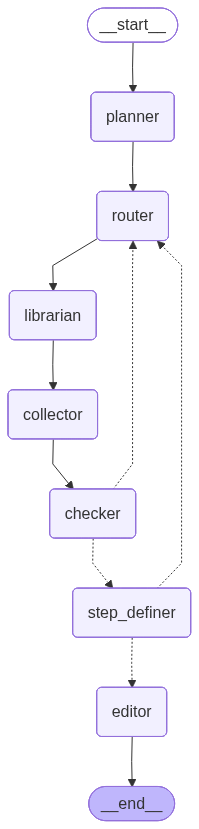

In [ ]:
# --- 1. Define Conditional Logic ---
def checker_decision(state: GraphState):
    feedback = state.get("feedback")
    
    if feedback == "retry":
        return "router"
        
    else: 
        return "step_definer"

def definer_decision(state: GraphState):
    feedback = state.get("feedback")
    
    if feedback == "finished":
        return "editor"
    else:
        return "router"

# --- Build the Graph ---
workflow = StateGraph(GraphState)

# Add Nodes
# Mapping your variable names to the roles
workflow.add_node("planner", planner_agent)
workflow.add_node("router", router_agent)
workflow.add_node("librarian", librarian_agent)
workflow.add_node("collector", extractor_agent)
workflow.add_node("validator", validator_agent)
workflow.add_node("step_definer", step_definer_agent) # <--- NEW NODE ADDED
workflow.add_node("editor", editor_agent)

# Set Entry Point
workflow.set_entry_point("planner")

# --- 3. Add Edges (The Wiring) ---

# Start: Plan -> First execution
workflow.add_edge("planner", "router")

# Execution Chain
workflow.add_edge("router", "librarian")
workflow.add_edge("librarian", "collector")
workflow.add_edge("collector", "validator")

# Conditional Edge 1: From Validator (validator)
workflow.add_conditional_edges(
    "validator",
    checker_decision,
    {
        "router": "router",           # Retry Loop
        "step_definer": "step_definer" # Success -> Refinement
    }
)

# Conditional Edge 2: From Step Definer
workflow.add_conditional_edges(
    "step_definer",
    definer_decision,
    {
        "router": "router", # Execute Next Refined Step
        "editor": "editor"  # Done
    }
)

# End
workflow.add_edge("editor", END)

# Compile
app = workflow.compile()

from IPython.display import Image, display

# Exibe a imagem correta do grafo
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [22]:
try:
    query_teste = "Quais são os órgãos que compõem a estrutura administrativa da EBSERH e qual é o regime de pessoal adotado pela empresa?"
    print(f"\n--- Testando com a query: '{query_teste}' ---")
    
    final_state = app.invoke({"query": query_teste}, {"recursion_limit": 50})
    
    print("\n--- RESULTADO FINAL ---")
    print(final_state.get('final_answer'))

    print("\n--- TOKEN REPORT ---")
    usage = final_state["token_usage"]
    print(f"Input Tokens:  {usage['input']}")
    print(f"Output Tokens: {usage['output']}")
    print(f"Total Tokens:  {usage['total']}")

except Exception as e:
    print(f"\nOcorreu um erro ao executar o grafo: {e}")


--- Testando com a query: 'Quais são os órgãos que compõem a estrutura administrativa da EBSERH e qual é o regime de pessoal adotado pela empresa?' ---
--- Agente: Leader (Planejamento) ---
Gerando plano...

 PLANO GERADO (2 passos):
  1. órgãos que compõem a estrutura administrativa da EBSERH
  2. regime de pessoal adotado pela EBSERH
------------------------------
--- Agente: Router (LLM Classification) ---
órgãos que compõem a estrutura administrativa da EBSERH
Routing Decision: executivo
--- Agente: Librarian (Buscando em 'executivo') ---
--- Librarian: 8 docs encontrados. ---
--- Agente: Coletor (Resumindo Evidências) ---
--- Agente: Fact Checker (Validação com Blacklist) ---
--- Decisão do Auditor: APROVADO ---
--- Próximo passo -> regime de pessoal adotado pela EBSERH ---
--- Agente: Step Definer (Refinando Próximo Passo) ---
--- Agente: Editor (Gerando Resposta Final) ---

--- RESULTADO FINAL ---
**Órgãos da estrutura administrativa da EBSERH**

- **Superintendente** – respons